## Imbalance learn

In [6]:
## imbalance learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sklearn modules
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector

# Import imblearn pipeline and oversampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


# Read the data and create the new column
data = pd.read_csv('../data/customer_base + drive score.csv')
data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']

# Drop unused columns
columns_to_drop = ['Subscriber Id', 'Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', # id
'1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level', 'sp_counts_customer_level', # target related
'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', # dates
'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model', 'First Order Requested Make', # vehicle
'days_run_in_accident', 'Credit Score Approval Status',
'License State',
'Most Recent Promo Code Used'] # others

Target = 'seasoning_3month_incident_Ind'
y = data[Target]
X = data.drop(columns=[Target] + columns_to_drop, axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define columns
miles_columns = ['Total Miles Driven', 'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Miles per Month']

numerical_columns_selector = selector(dtype_include=np.number)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

# Exclude miles_columns from these groups
numerical_columns = list(set(numerical_columns) - set(miles_columns))
categorical_columns = list(set(categorical_columns) - set(miles_columns))

# Preprocessor for numeric columns (excluding miles)
numeric_transformer = Pipeline(
steps=[
("imputer_num", SimpleImputer(strategy="median")),
("scaler", StandardScaler())
]
)

# Preprocessor for miles columns
miles_transformer = Pipeline(
steps=[
("imputer_num", SimpleImputer(strategy="constant", fill_value=0)),
("scaler", StandardScaler())
]
)

# Preprocessor for categorical columns
categorical_transformer = Pipeline(
steps=[
("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')),
("encode", OrdinalEncoder())
]
)

# Combine preprocessors using ColumnTransformer
preprocessor = ColumnTransformer(
transformers=[
("num", numeric_transformer, list(numerical_columns)),
("miles", miles_transformer, list(miles_columns)),
("cat", categorical_transformer, list(categorical_columns)),
]
)

# Create the pipeline with preprocessing, oversampling, and the classifier.
# Note: We use the imblearn.pipeline.Pipeline so that the oversampling step is integrated.
steps = [
('preprocess', preprocessor),
('oversample', RandomOverSampler(random_state=42)), # oversample rare class
# If you prefer SMOTE, you can replace the above with:
# ('oversample', SMOTE(random_state=42)),
('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))
]

model = ImbPipeline(steps)

# Fit the pipeline on the training data
model.fit(X_train, y_train)

# Evaluate on the test set
print("Test set score:", model.score(X_test, y_test))


Test set score: 0.9609321453050035


In [7]:

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))

------------------- Confusion Matric -------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1409
           1       0.11      0.02      0.03        50

    accuracy                           0.96      1459
   macro avg       0.54      0.51      0.51      1459
weighted avg       0.94      0.96      0.95      1459



## DEA

In [8]:
data = pd.read_csv('../data/incident_data_all.csv')
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5948 entries, 0 to 5947
Data columns (total 123 columns):
 #    Column                                                 Dtype  
---   ------                                                 -----  
 0    days_run_in_accident                                   float64
 1    days_run_in_mp                                         float64
 2    1st_sp_date_customer_level                             object 
 3    1st_mp_date_customer_level                             object 
 4    1st_incident                                           object 
 5    seasoning_3month_incident_Ind                          int64  
 6    seasoning_3month_mp_Ind                                int64  
 7    Subscriber Id                                          object 
 8    Creation Date                                          object 
 9    Month of Creation Date                                 float64
 10   Gender First Name Estimated                            obj

<Axes: ylabel='Frequency'>

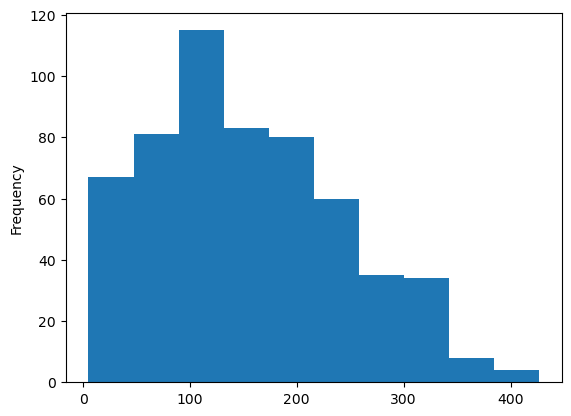

In [9]:
data['days_run_in_mp'].plot(kind='hist')

<Axes: ylabel='Frequency'>

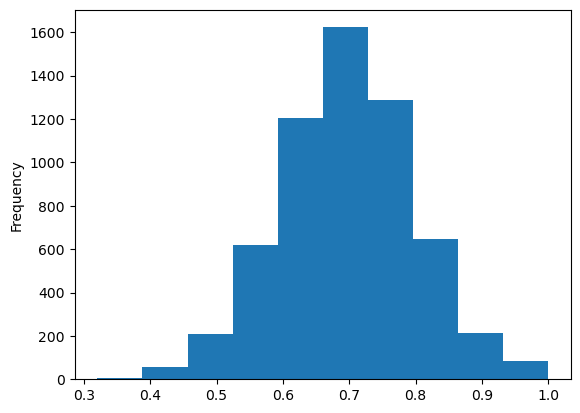

In [10]:
data['score_mean'].plot(kind='hist')

## with oscilar features

In [171]:
data_name = 'incident_test_data/incident_data_all_10.6_test.csv'
path = '../data/' + data_name
data = pd.read_csv(path)
# data.info(verbose=True)

### get data from snowflake

In [172]:
import snowflake.connector
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")

conn = snowflake.connector.connect(
    user='YAQIWU11235',
    password='nut3yub2tzh7MPA.dnc',
    account='MCB49099-KHB29787',
    warehouse='OSCILAR_TO_SNOWFLAKE',
    database = 'FLEXCAR_OSCILAR',
    schema = 'OSCILAR_SCHEMA'
    )

accident_df = pd.read_csv(path)

# subscriber who is step-up eligible
# q = f"select * from input_flexcar_account_creation_v2 where SUBSCRIBERID in {tuple(data['Subscriber Id'])};"

# q = f"""WITH ranked_records AS (
#         SELECT
#             *,
#             ROW_NUMBER() OVER (
#             PARTITION BY subscriberid
#             ORDER BY
#                 accountcreationdate DESC
#             ) AS rn
#         FROM
#             input_flexcar_account_creation_v2
#         WHERE
#             subscriberid in {tuple(data['Subscriber Id'])}
#         )
#         SELECT
#          *
#         FROM
#         ranked_records
#         WHERE
#         rn = 1;
#         """



columns = ["Subscriber Id",
           "Created At",
            "ClearID_TotalScore",
            "RiskInform_TotalScore",
            "RiskInform_AddressFlags_TotalScore",
            "RiskInform_CriminalFlags_TotalScore",
            "RiskInform_Custom_TotalScore",
            "RiskInform_SingleRiskIndicators_TotalScore",
            "RiskInform_SyntheticIdentity_TotalScore"
        ]

# q = f"""WITH ranked_records AS (
#             SELECT
#                  "Subscriber Id",
#                  "Created At",
#                 "ClearID_TotalScore",
#                 "RiskInform_TotalScore",
#                 "RiskInform_AddressFlags_TotalScore",
#                 "RiskInform_CriminalFlags_TotalScore",
#                 "RiskInform_Custom_TotalScore",
#                 "RiskInform_SingleRiskIndicators_TotalScore",
#                 "RiskInform_SyntheticIdentity_TotalScore",
#                 ROW_NUMBER() OVER (PARTITION BY "Subscriber Id"
#             ORDER BY
#                     "Created At" DESC
#                 ) AS rn
#             FROM
#                 tr_attributes
#             WHERE
#                 "Subscriber Id" in {tuple(data['Subscriber Id'])}
#             )
#             SELECT
#             *
#             FROM
#             ranked_records
#             WHERE
#             rn = 1;
#     """


q = f"""
    WITH tr AS (
            SELECT
                 "Subscriber Id",
                 "Created At",
                "ClearID_TotalScore",
                "RiskInform_TotalScore",
                "RiskInform_AddressFlags_TotalScore",
                "RiskInform_CriminalFlags_TotalScore",
                "RiskInform_Custom_TotalScore",
                "RiskInform_SingleRiskIndicators_TotalScore",
                "RiskInform_SyntheticIdentity_TotalScore",
            FROM
                tr_attributes
            WHERE
                "Subscriber Id" in {tuple(accident_df['Subscriber Id'])}
            ),
            
    combine_data as (
        select tr."Subscriber Id" as subscriberId, 
               tr."Created At" as createdAt,
               * 
        from tr
        join METHOD_ATTRIBUTES as m 
             on tr."Subscriber Id" = m."Subscriber Id" 
             and tr."Created At" = m."Created At"
        join SENTILINK_ATTRIBUTES as s 
            on tr."Subscriber Id" = s."Subscriber Id"
            and tr."Created At" = s."Created At"
    ),
    combine_data_rn as (
         select *,  
               row_number() over(partition by subscriberId order by createdAt) as rn
        from combine_data
    )
select * 
from combine_data_rn 
where rn = 1;
"""

# get the column names
# q_col = "show columns in tr_attributes;"

with conn.cursor() as cur:
    df = cur.execute(q).fetchall()
    # col_data = cur.execute(q_col).fetchall()

# col_names = []
# for col in col_data:
#     col_names.append(col[2])
# col_names.append('rn')

# col_names = columns + ['rk']

col_names = ["SUBSCRIBERID", "CREATEDAT", "Subscriber Id", "Created At", "ClearID_TotalScore", "RiskInform_TotalScore", 
             "RiskInform_AddressFlags_TotalScore", "RiskInform_CriminalFlags_TotalScore", "RiskInform_Custom_TotalScore", 
             "RiskInform_SingleRiskIndicators_TotalScore", "RiskInform_SyntheticIdentity_TotalScore", "Subscriber Id", "Created At", 
             "Subscriber_RunDate_JoinKey", "creditScore", "Flexscore", "PriorAuto_AtLeastOneGoodStanding", "PriorAuto_AtLeastOneMajorDelinquency", 
             "PriorAuto_AtLeastOnePastDue", "PriorAuto_AllInGoodStanding", "PriorAuto_Repossession", "PriorAuto_Chargeoff", "PriorAuto_DelinquentEvent", 
             "PriorCC_Chargeoff", "PriorCC_AtLeastOneGoodStanding", "PriorCC_AtLeastOneMajorDelinquency", "PriorCC_AtLeastOnePastDue", 
             "PriorCC_AllInGoodStanding", "PriorCC_Chargeoff_or_PriorAuto_Repo", "PriorCC_Chargeoff_or_PriorAuto_Chargeoff", "AnyPriorDelinquentEvent", 
             "AutoBalances", "AutoDebtLoad", "AutoMinimumPayment", "AutoOriginalLoanAmts", "CCBalances", "CCDebtLoad", "CCLimits", "CCMinimumPayment", 
             "MortgageBalances", "MortgageDebtLoad", "MortgageMinimumPayment", "MortgageOriginalLoanAmts", "StudentBalances", "StudentDebtLoad", 
             "StudentMinimumPayment", "StudentOriginalLoanAmts", "TotalDebtLoad", "TotalMinimumPayment", "MonthlyPaymentToIncome", "Subscriber Id", 
             "Created At", "Subscriber_RunDate_JoinKey", "creditScore", "Serial_Disputer", "Auth_User_Purchaser", "Flexscore", "FirstPartyFraud", "IDTheft", "RN"
]

oscilar_data = pd.DataFrame(df, columns=col_names)

# oscilar_data = pd.DataFrame(df)



### drop some data

In [173]:
# dropping the missing data > 0.3
missing_ratio = oscilar_data.isnull().mean() 
col_to_drop_m = missing_ratio[missing_ratio>0.3].index.to_list()
oscilar_data.drop(columns=col_to_drop_m, inplace=True)
# remove unwanted columns
oscilar_data = oscilar_data.iloc[:, :-1]

In [174]:
oscilar_data.shape # check the shape
# oscilar_data.SUBSCRIBERID.value_counts()

(1449, 44)

In [175]:
# join the oscilar data to the accident data
data_comb = accident_df.merge(oscilar_data, left_on='Subscriber Id', right_on='SUBSCRIBERID')
duplicate_columns = data_comb.columns[data_comb.columns.duplicated(keep='first')]
data_comb = data_comb.drop(columns=duplicate_columns)
# data_comb['seasoning_month_incident_Ind'] = data_comb['days_run_in_accident'].map(lambda x: 1 if 0 < x < 30 else 0) # add 1 month accident ind

### wrap the model into function

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE


## help functions
def month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    

def score_to_bascket(score):
    if score < 0.6:
        return 1
    elif 0.6 < score < 0.8:
        return 2
    else:
        return 3


def run_as_select(target = 'seasoning_3month_incident_Ind', data=data_comb.copy()):
    """ 
    target need to be any of below:
        'seasoning_3month_mp_Ind', 
        'seasoning_month_mp_Ind', 
        'seasoning_3month_incident_Ind',
        'seasoning_month_incident_Ind',
    """
    # data = pd.read_csv('../data/customer_base + drive score.csv')
    # data = pd.read_csv('../data/incident_data_all.csv')
    # data = data_comb.copy()
    data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']
    data['season'] = data['Month of Creation Date'].map(month_to_season)
    # data['seasoning_month_incident_Ind'] = data['days_run_in_accident'].map(lambda x: 1 if 0 < x < 30 else 0)
    # data['seasoning_month_mp_Ind'] = data['days_run_in_mp'].map(lambda x: 1 if 0 < x < 30 else 0)
    data['score_basket'] = data['score_mean'].map(score_to_bascket)
    data['score_q1_vs_mean'] = data['score_q1'] - data['score_mean']
    data['score_q3_vs_mean'] = data['score_q3'] - data['score_mean']

    # columns to drop
    columns_to_drop = ['Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', 'Subui Creation Date', ## id
                    # '1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 
                    'mp_counts_customer_level',  'sp_counts_customer_level',  # target relatd
                    # 'Creation Date', 
                    'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', 'Day of 1st_incident', # date and time
                    'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model',  'First Order Requested Make', # vehicle
                    'Days With Vehicle', 'Days Since First Order', 'Active Weeks',  # days related to miles
                    'Total Tax Amount', 'Total Revenue', 'Total Collected Revenue', 'Total Collected Vehicle Amount', 'Total Receipts', 'Total Paid Invoices', 'Total Collected Mileage Amount', 'Total Collected Fee Amount', 'Total Paid Mileage Invoices', # revenue realted features
                        'Credit Score Approval Status', 
                    'License State',
                    'Most Recent Promo Code Used', # others
                    'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Total Miles Driven', # miles
                    # 'seasoning_3month_mp_Ind', 
                    # 'seasoning_month_mp_Ind', 
                    'seasoning_3month_incident_Ind',
                    # 'seasoning_month_incident_Ind',
                    'Miles per Month', 'Miles Driven', # miles driven
                    'score_q1', 'score_q2', 'score_q3', 
                    # 'score_mean',
                    ]

    subscriber_col = []
    for col in data.columns:
        if 'subscriber' in col.lower():
            subscriber_col.append(col)

    # Target = 'seasoning_month_mp_Ind'
    Target = target

    columns_to_drop.remove(Target)

    y = data[Target]
    X = data.drop(columns = [Target] + subscriber_col +columns_to_drop, axis=1)

    temp = data.drop(columns = columns_to_drop, axis=1)
    temp.to_csv('../data/incident_test_data/h2o_incident_data_all_6.12_test.csv', index=False)
    temp1 = temp[temp['seasoning_3month_sp+mp'] != 0]
    temp1.to_csv('../data/incident_test_data/h2o_mp_data_6.12_test.csv', index=False)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    miles_columns = []

    numerical_columns_selector = selector(dtype_include=np.number)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(X_train)
    categorical_columns = categorical_columns_selector(X_train)

    # update num and cat columns
    numerical_columns = list(set(numerical_columns) - set(miles_columns))
    categorical_columns = list(set(categorical_columns) - set(miles_columns))

    # preprocesser
    numeric_transformer = Pipeline(
        steps=[("imputer_num", 
                SimpleImputer(strategy="median")), 
                # SimpleImputer(strategy="constant", fill_value=0)), 
                ("scaler", StandardScaler())]
    )

    miles_transformer = Pipeline(
        steps=[("imputer_num", 
                SimpleImputer(strategy="constant", fill_value=0)), 
                ("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        steps=[("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')), 
            ("encode", OneHotEncoder(handle_unknown='ignore',drop='if_binary'))]
    )


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, list(numerical_columns)),
            ("miles", miles_transformer, list(miles_columns)),
            ("cat", categorical_transformer, list(categorical_columns)),
        ]
    )

    steps = [('preprocess', preprocessor),
            #  ('oversample', RandomOverSampler(random_state=42)),
            # ('rf', XGBClassifier())
            ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))
            ]

    model = Pipeline(steps)
    model_rf = model.fit(X_train, y_train)

    ## feature impartant
    # feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
    # feature_importances.sort_values(by=0, ascending=False).head(20)
    feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
    print('Feature impartance:')
    print('---------------------------------------------------------')
    print(feature_importances.sort_values(by=0, ascending=False).head(20))
    print('\n')

    ## confusion matrix
    from sklearn.metrics import roc_auc_score
    print('---------- ROC_AUC_score-------------')
    print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
    print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))
    print('\n')

    from sklearn.metrics import matthews_corrcoef
    print('---------- MCC_score-------------')
    print('Training data:', matthews_corrcoef(y_train, model_rf.predict(X_train)))
    print('Test data:', matthews_corrcoef(y_test, model_rf.predict(X_test)))
    print('\n')

    from sklearn.metrics import confusion_matrix
    print('------------------- Confusion Matric -------------------')
    y_test_pred= model_rf.predict(X_test)
    # print(confusion_matrix(y_test, y_test_pred, labels=[0,1]))
    y_test.name = 'Actual'
    y_test_pred = pd.Series(y_test_pred, name='Predict')
    print(pd.crosstab(y_test, y_test_pred))
    print('\n')


    from sklearn.metrics import classification_report
    print('------------------- classification_report -------------------')
    target_names = ['0', '1']
    y_test_pred= model_rf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print('\n')


    ## shap
    import shap
    X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
    clf = model_rf.named_steps["rf"]
    columns = model_rf.named_steps['preprocess'].get_feature_names_out()
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_transformed)
    shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)
    # X = data.drop(columns=[Target]+['Subscriber Id'], axis=1)


def run_as_select_imbalance(target = 'seasoning_3month_incident_Ind', data=data_comb.copy()):
    """ 
    target need to be any of below:
        'seasoning_3month_mp_Ind', 
        'seasoning_month_mp_Ind', 
        'seasoning_3month_incident_Ind',
        'seasoning_month_incident_Ind',
    """
    # data = pd.read_csv('../data/customer_base + drive score.csv')
    # data = pd.read_csv('../data/incident_data_all.csv')
    # data = data_comb.copy()
    data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']
    data['season'] = data['Month of Creation Date'].map(month_to_season)
    # data['seasoning_month_incident_Ind'] = data['days_run_in_accident'].map(lambda x: 1 if 0 < x < 30 else 0)
    data['seasoning_month_mp_Ind'] = data['days_run_in_mp'].map(lambda x: 1 if 0 < x < 30 else 0)
    data['score_basket'] = data['score_mean'].map(score_to_bascket)
    data['score_q1_vs_mean'] = data['score_q1'] - data['score_mean']
    data['score_q3_vs_mean'] = data['score_q3'] - data['score_mean']

    # columns to drop
    columns_to_drop = ['Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', 'Subui Creation Date', ## id
                    '1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level',  'sp_counts_customer_level',  # target relatd
                    'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', 'Day of 1st_incident', # date and time
                    'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model',  'First Order Requested Make', # vehicle
                    'days_run_in_accident',  'Days With Vehicle', 'Days Since First Order', 'Active Weeks', 'days_run_in_mp', # days related to miles
                    'Total Tax Amount', 'Total Revenue', 'Total Collected Revenue', 'Total Collected Vehicle Amount', 'Total Receipts', 'Total Paid Invoices', 'Total Collected Mileage Amount', 'Total Collected Fee Amount', 'Total Paid Mileage Invoices', # revenue realted features
                        'Credit Score Approval Status', 
                    'License State',
                    'Most Recent Promo Code Used', # others
                    'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Total Miles Driven', # miles
                    # 'seasoning_3month_mp_Ind', 
                    'seasoning_month_mp_Ind', 
                    # 'seasoning_3month_incident_Ind',
                    'seasoning_month_incident_Ind',
                    'Miles per Month', 'Miles Driven', # miles driven
                    'score_q1', 'score_q2', 'score_q3', 
                    # 'score_mean',
                    ]

    subscriber_col = []
    for col in data.columns:
        if 'subscriber' in col.lower():
            subscriber_col.append(col)

    # Target = 'seasoning_month_mp_Ind'
    Target = target

    columns_to_drop.remove(Target)

    y = data[Target]
    X = data.drop(columns = [Target] + subscriber_col +columns_to_drop, axis=1)    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    miles_columns = []

    numerical_columns_selector = selector(dtype_include=np.number)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(X_train)
    categorical_columns = categorical_columns_selector(X_train)

    # update num and cat columns
    numerical_columns = list(set(numerical_columns) - set(miles_columns))
    categorical_columns = list(set(categorical_columns) - set(miles_columns))

    # preprocesser
    numeric_transformer = Pipeline(
        steps=[("imputer_num", 
                SimpleImputer(strategy="median")), 
                # SimpleImputer(strategy="constant", fill_value=0)), 
                ("scaler", StandardScaler())]
    )

    miles_transformer = Pipeline(
        steps=[("imputer_num", 
                SimpleImputer(strategy="constant", fill_value=0)), 
                ("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        steps=[("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')), 
            ("encode", OneHotEncoder(handle_unknown='ignore',drop='if_binary'))]
    )


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, list(numerical_columns)),
            ("miles", miles_transformer, list(miles_columns)),
            ("cat", categorical_transformer, list(categorical_columns)),
        ]
    )

    steps = [('preprocess', preprocessor),
            #  ('oversample', RandomOverSampler(random_state=42)),
            # ('rf', XGBClassifier()),
            ("SMOTE", SMOTE()),
            ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))
            ]

    model = ImbPipeline(steps)
    model_rf = model.fit(X_train, y_train)

    ## feature impartant
    # feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
    # feature_importances.sort_values(by=0, ascending=False).head(20)
    # feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
    # print('Feature impartance:')
    # print('---------------------------------------------------------')
    # print(feature_importances.sort_values(by=0, ascending=False).head(20))
    # print('\n')

    ## confusion matrix
    from sklearn.metrics import roc_auc_score
    print('---------- ROC_AUC_score-------------')
    print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
    print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))
    print('\n')

    from sklearn.metrics import matthews_corrcoef
    print('---------- MCC_score-------------')
    print('Training data:', matthews_corrcoef(y_train, model_rf.predict(X_train)))
    print('Test data:', matthews_corrcoef(y_test, model_rf.predict(X_test)))
    print('\n')

    from sklearn.metrics import confusion_matrix
    print('------------------- Confusion Matric -------------------')
    y_test_pred= model_rf.predict(X_test)
    # print(confusion_matrix(y_test, y_test_pred, labels=[0,1]))
    y_test.name = 'Actual'
    y_test_pred = pd.Series(y_test_pred, name='Predict')
    print(pd.crosstab(y_test, y_test_pred))
    print('\n')


    from sklearn.metrics import classification_report
    print('------------------- classification_report -------------------')
    target_names = ['0', '1']
    y_test_pred= model_rf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print('\n')


    # ## shap
    # import shap
    # X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
    # clf = model_rf.named_steps["rf"]
    # columns = model_rf.named_steps['preprocess'].get_feature_names_out()
    # explainer = shap.TreeExplainer(clf)
    # shap_values = explainer.shap_values(X_transformed)
    # shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)





### run in accident in 3 momth

In [177]:
run_as_select(target='seasoning_3month_incident_Ind', data=data_comb.copy())

Feature impartance:
---------------------------------------------------------
                                                        0
num__seasoning_3month_sp+mp                      0.188077
num__Percent Active                              0.025515
num__score_std                                   0.023987
num__score_mean                                  0.023002
num__Total Uncollected Revenue                   0.022463
num__score_q3_vs_mean                            0.022091
num__cornering_per_1000miles                     0.018984
num__speeding_per_1000miles                      0.018961
num__CCBalances                                  0.018858
num__IDTheft                                     0.018361
num__score_q1_vs_mean                            0.018030
num__ClearID_TotalScore                          0.016186
num__CCDebtLoad                                  0.015269
cat__Creation Date_2025-04-22 20:22:24           0.015056
num__TotalDebtLoad                               0.0

UFuncTypeError: Cannot cast ufunc 'isnan' input from dtype('O') to dtype('bool') with casting rule 'same_kind'

In [38]:
run_as_select_imbalance(target='seasoning_3month_incident_Ind', data=data_comb.copy())

ValueError: list.remove(x): x not in list

### run in accident in 1 month

Feature impartance:
---------------------------------------------------------
                                                        0
num__score_std                                   0.035824
num__score_q3_vs_mean                            0.034242
num__score_mean                                  0.034075
num__braking_per_1000miles                       0.033231
num__score_q1_vs_mean                            0.031792
num__ClearID_TotalScore                          0.029199
num__Percent Active                              0.028343
num__CCBalances                                  0.027006
num__speeding_per_1000miles                      0.026834
num__IDTheft                                     0.024682
num__TotalDebtLoad                               0.024333
num__cornering_per_1000miles                     0.024192
num__Total Invoices With Initial Payment Failed  0.022946
num__Total Paid Vehicle Fee Invoices             0.022882
num__Average Initial Failure Rate                0.0

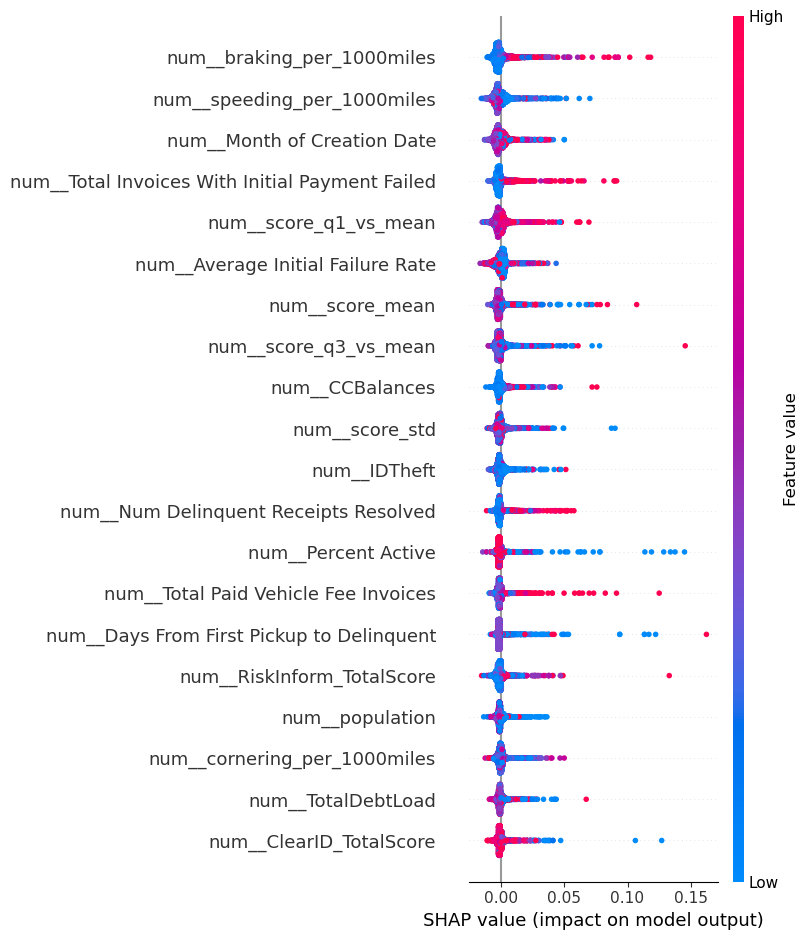

In [ ]:
run_as_select(target='seasoning_3month_incident_Ind', data=data_comb.copy())

### mp vs sp given an accident - 3 month

In [22]:
data_comb_incident = data_comb[data_comb['seasoning_3month_incident_Ind'] == 1]
print('Total number of observation: ', data_comb_incident.shape)
run_as_select(target='seasoning_3month_mp_Ind', data=data_comb_incident.copy())

Total number of observation:  (197, 154)


ValueError: list.remove(x): x not in list

### mp vs sp given an accident - 1 month

Total number of observation:  (52, 154)
Feature impartance:
---------------------------------------------------------
                                                        0
num__TotalDebtLoad                               0.060268
num__speeding_per_1000miles                      0.053069
num__braking_per_1000miles                       0.052461
num__Month of Creation Date                      0.045533
num__score_std                                   0.041841
num__score_q1_vs_mean                            0.034304
num__CCBalances                                  0.033907
num__Total Invoices With Initial Payment Failed  0.029247
num__Num Delinquent Receipts Resolved            0.026780
num__Average Initial Failure Rate                0.023359
num__ClearID_TotalScore                          0.022387
num__TotalMinimumPayment                         0.022225
num__PriorCC_Chargeoff_or_PriorAuto_Chargeoff    0.022147
cat__Has Open Order_yes                          0.020999
num__IDTheft

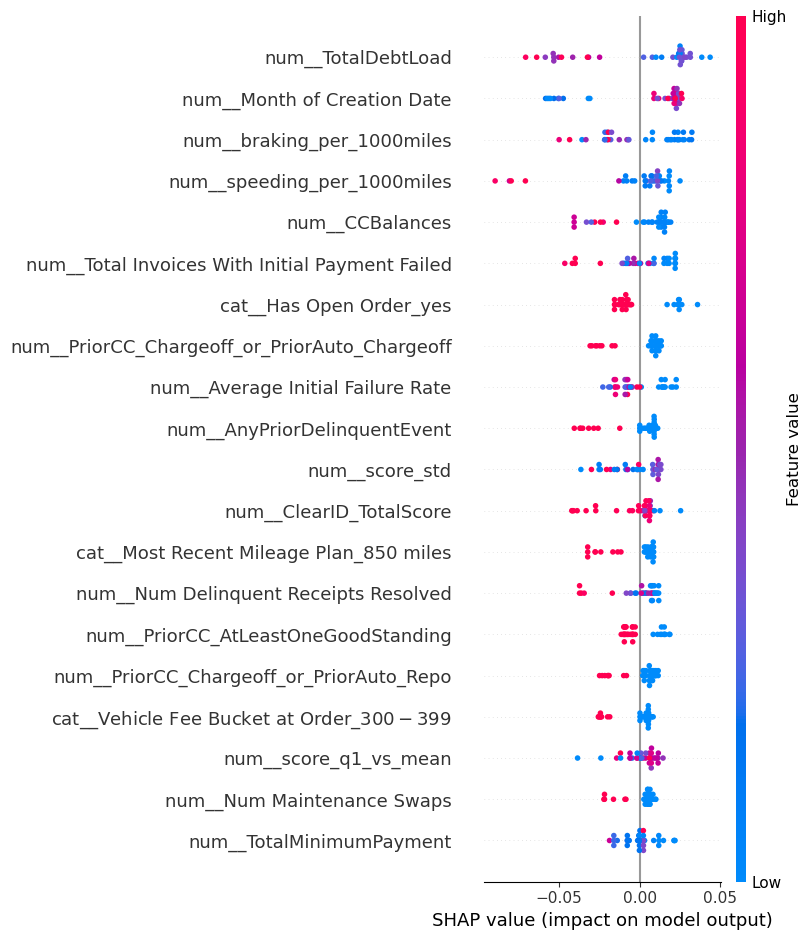

In [ ]:
data_comb_incident = data_comb[data_comb['seasoning_month_incident_Ind'] == 1]
print('Total number of observation: ', data_comb_incident.shape)
run_as_select(target='seasoning_month_mp_Ind', data=data_comb_incident.copy())

## sklearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


## functions
def month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    

def score_to_bascket(score):
    if score < 0.6:
        return 1
    elif 0.6 < score < 0.8:
        return 2
    else:
        return 3

# data = pd.read_csv('../data/customer_base + drive score.csv')
data = pd.read_csv('../data/incident_data_all.csv')
data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']
data['season'] = data['Month of Creation Date'].map(month_to_season)
data['seasoning_6month_incident_Ind'] = data['days_run_in_accident'].map(lambda x: 1 if x < 180 else 0)
data['score_basket'] = data['score_mean'].map(score_to_bascket)

columns_to_drop = ['Subscriber Id', 'Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', 'Subui Creation Date', ## id
                   '1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level',  'sp_counts_customer_level',  # target relatd
                   'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', 'Day of 1st_incident', # date and time
                   'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model',  'First Order Requested Make', # vehicle
                   'days_run_in_accident',  'Days With Vehicle', 'Days Since First Order', 'Active Weeks', 'days_run_in_mp', # days related to miles
                   'Total Tax Amount', 'Total Revenue', 'Total Collected Revenue', 'Total Collected Vehicle Amount', 'Total Receipts', 'Total Paid Invoices', 'Total Collected Mileage Amount', 'Total Collected Fee Amount', 'Total Paid Mileage Invoices', # revenue realted features
                    'Credit Score Approval Status', 
                   'License State',
                   'Most Recent Promo Code Used', # others
                   'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Total Miles Driven', # miles
                   'seasoning_3month_mp_Ind',  'seasoning_6month_incident_Ind',
                   'Miles per Month', 'Miles Driven', # miles driven
                'score_q1', 'score_q2', 'score_q3', 'score_mean',
                   ]


Target = 'seasoning_3month_incident_Ind'
y = data[Target]
X = data.drop(columns=[Target]+columns_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

miles_columns = []

numerical_columns_selector = selector(dtype_include=np.number)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

# update num and cat columns
numerical_columns = list(set(numerical_columns) - set(miles_columns))
categorical_columns = list(set(categorical_columns) - set(miles_columns))

# preprocesser
numeric_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="median")), 
            # SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

miles_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')), 
           ("encode", OneHotEncoder(handle_unknown='ignore',drop='if_binary'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(numerical_columns)),
        ("miles", miles_transformer, list(miles_columns)),
        ("cat", categorical_transformer, list(categorical_columns)),
    ]
)

steps = [('preprocess', preprocessor),
        #  ('oversample', RandomOverSampler(random_state=42)),
         ('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))]

model = Pipeline(steps)
model_rf = model.fit(X_train, y_train)

## feature impartant
# feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
# feature_importances.sort_values(by=0, ascending=False).head(20)
feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
print('Feature impartance:')
print('---------------------------------------------------------')
print(feature_importances.sort_values(by=0, ascending=False).head(20))
print('\n')

## confusion matrix
from sklearn.metrics import roc_auc_score
print('---------- ROC_AUC_score-------------')
print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))
print('\n')

from sklearn.metrics import matthews_corrcoef
print('---------- MCC_score-------------')
print('Training data:', matthews_corrcoef(y_train, model_rf.predict(X_train)))
print('Test data:', matthews_corrcoef(y_test, model_rf.predict(X_test)))

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model_rf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))
print('\n')


## shap
import shap
X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
clf = model_rf.named_steps["rf"]
columns = model_rf.named_steps['preprocess'].get_feature_names_out()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)

In [ ]:
len(numerical_columns) + len(categorical_columns)

In [ ]:
# from sklearn.metrics import roc_auc_score

# print('---------- ROC_AUC_score-------------')
# print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
# print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

# from sklearn.metrics import classification_report
# print('------------------- Confusion Matric -------------------')
# target_names = ['0', '1']
# y_test_pred= model_rf.predict(X_test)
# print(classification_report(y_test, y_test_pred, target_names=target_names))

In [ ]:
# import shap
# X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
# clf = model_rf.named_steps["rf"]
# columns = model_rf.named_steps['preprocess'].get_feature_names_out()
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_transformed)
# shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)

## sp vs mp

In [ ]:
data = pd.read_csv('../data/incident_sp_vs_mp.csv')
data['Mileage Plan at Order'].value_counts()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


## functions
def month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# data = pd.read_csv('../data/customer_base + drive score.csv')
data = pd.read_csv('../data/incident_data_all.csv')

data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']
data['season'] = data['Month of Creation Date'].map(month_to_season)
data['seasoning_6month_incident_Ind'] = data['days_run_in_accident'].map(lambda x: 1 if x < 180 else 0)
data['seasoning_6month_mp_Ind'] = data['days_run_in_mp'].map(lambda x: 1 if x < 180 else 0)

data = data[data['seasoning_6month_incident_Ind'] == 1] # filter out all incident record

columns_to_drop = ['Subscriber Id', 'Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', 'Subui Creation Date', ## id
                   '1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level',  'sp_counts_customer_level',  # target relatd
                   'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', 'Day of 1st_incident', # date and time
                   'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model',  'First Order Requested Make', # vehicle
                   'days_run_in_accident',  'Days With Vehicle', 'Days Since First Order', 'Active Weeks', 'days_run_in_mp', # days related to miles
                   'Total Tax Amount', 'Total Revenue', 'Total Collected Revenue', 'Total Collected Vehicle Amount', 'Total Receipts', 'Total Paid Invoices', 'Total Collected Mileage Amount', 'Total Collected Fee Amount', 'Total Paid Mileage Invoices', # revenue realted features
                    'Credit Score Approval Status', 
                   'License State',
                   'Most Recent Promo Code Used', # others
                   'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Total Miles Driven', # miles
                   'seasoning_3month_mp_Ind', 'seasoning_3month_incident_Ind', 
                   'Miles per Month', 'Miles Driven', # miles driven
                   ]
Target = 'seasoning_6month_mp_Ind'
y = data[Target]
X = data.drop(columns=[Target]+columns_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

miles_columns = []

numerical_columns_selector = selector(dtype_include=np.number)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

# update num and cat columns
numerical_columns = list(set(numerical_columns) - set(miles_columns))
categorical_columns = list(set(categorical_columns) - set(miles_columns))

# preprocesser
numeric_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="median")), 
            # SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

miles_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')), 
           ("encode", OneHotEncoder(handle_unknown='ignore'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(numerical_columns)),
        ("miles", miles_transformer, list(miles_columns)),
        ("cat", categorical_transformer, list(categorical_columns)),
    ]
)

steps = [('preprocess', preprocessor),
        #  ('oversample', RandomOverSampler(random_state=42)),
         ('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))]

model = Pipeline(steps)
model_rf = model.fit(X_train, y_train)

## feature impartant
# feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
# feature_importances.sort_values(by=0, ascending=False).head(20)
feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
print('Feature impartance:')
print('---------------------------------------------------------')
print(feature_importances.sort_values(by=0, ascending=False).head(20))
print('\n')

## confusion matrix
from sklearn.metrics import roc_auc_score

print('---------- ROC_AUC_score-------------')
print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model_rf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))
print('\n')


## shap
import shap
X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
clf = model_rf.named_steps["rf"]
columns = model_rf.named_steps['preprocess'].get_feature_names_out()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)

In [ ]:
### model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


## functions
def month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    

def score_to_bascket(score):
    if score < 0.6:
        return 1
    elif 0.6 < score < 0.8:
        return 2
    else:
        return 3

# data = pd.read_csv('../data/customer_base + drive score.csv')
# data = pd.read_csv('../data/incident_data_all.csv')
data = data_comb.copy()
data['vehivel_request_fufillment'] = data['Vehicle Requests Make Model List'] == data['Most Recent Vehicle Request Assigned Make Model']
data['season'] = data['Month of Creation Date'].map(month_to_season)
data['seasoning_month_incident_Ind'] = data['days_run_in_accident'].map(lambda x: 1 if 0 < x < 30 else 0)
data['seasoning_month_mp_Ind'] = data['days_run_in_mp'].map(lambda x: 1 if 0 < x < 30 else 0)
data['score_basket'] = data['score_mean'].map(score_to_bascket)

# columns to drop
columns_to_drop = ['Most Recent Invoice Order Id', 'First Invoice Id', 'Most Recent Invoice Id', 'First Invoice Order Id', 'Subui Creation Date', ## id
                   '1st_incident', '1st_mp_date_customer_level', '1st_sp_date_customer_level', 'mp_counts_customer_level',  'sp_counts_customer_level',  # target relatd
                   'Creation Date', 'First Invoice Date', 'Most Recent Invoice Date', 'Driving Record Updated At', 'Driving Record Creation Time', 'Day of 1st_incident', # date and time
                   'Vehicle Requests Make Model List', 'Most Recent Vehicle Request Requested Make Model', 'Most Recent Vehicle Request Assigned Make Model',  'First Order Requested Make', # vehicle
                   'days_run_in_accident',  'Days With Vehicle', 'Days Since First Order', 'Active Weeks', 'days_run_in_mp', # days related to miles
                   'Total Tax Amount', 'Total Revenue', 'Total Collected Revenue', 'Total Collected Vehicle Amount', 'Total Receipts', 'Total Paid Invoices', 'Total Collected Mileage Amount', 'Total Collected Fee Amount', 'Total Paid Mileage Invoices', # revenue realted features
                    'Credit Score Approval Status', 
                   'License State',
                   'Most Recent Promo Code Used', # others
                   'Total Miles Driven Monthly', 'Total Miles Driven Pre Monthly', 'Miles per Week', 'Total Miles Driven', # miles
                   'seasoning_3month_mp_Ind', 
                   'seasoning_month_mp_Ind', 
                   'seasoning_3month_incident_Ind',
                   'seasoning_month_incident_Ind',
                   'Miles per Month', 'Miles Driven', # miles driven
                #    'score_q1', 'score_q2', 'score_q3', 'score_mean',
                   ]

subscriber_col = []
for col in data_comb.columns:
    if 'subscriber' in col.lower():
        subscriber_col.append(col)

Target = 'seasoning_month_mp_Ind'

columns_to_drop.remove(Target)

y = data[Target]
X = data.drop(columns = [Target] + subscriber_col +columns_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

miles_columns = []

numerical_columns_selector = selector(dtype_include=np.number)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

# update num and cat columns
numerical_columns = list(set(numerical_columns) - set(miles_columns))
categorical_columns = list(set(categorical_columns) - set(miles_columns))

# preprocesser
numeric_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="median")), 
            # SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

miles_transformer = Pipeline(
    steps=[("imputer_num", 
            SimpleImputer(strategy="constant", fill_value=0)), 
            ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer_cat", SimpleImputer(strategy="constant", fill_value='missing')), 
           ("encode", OneHotEncoder(handle_unknown='ignore',drop='if_binary'))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(numerical_columns)),
        ("miles", miles_transformer, list(miles_columns)),
        ("cat", categorical_transformer, list(categorical_columns)),
    ]
)

steps = [('preprocess', preprocessor),
        #  ('oversample', RandomOverSampler(random_state=42)),
         ('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))]

model = Pipeline(steps)
model_rf = model.fit(X_train, y_train)

## feature impartant
# feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
# feature_importances.sort_values(by=0, ascending=False).head(20)
feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
print('Feature impartance:')
print('---------------------------------------------------------')
print(feature_importances.sort_values(by=0, ascending=False).head(20))
print('\n')

## confusion matrix
from sklearn.metrics import roc_auc_score
print('---------- ROC_AUC_score-------------')
print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))
print('\n')

from sklearn.metrics import matthews_corrcoef
print('---------- MCC_score-------------')
print('Training data:', matthews_corrcoef(y_train, model_rf.predict(X_train)))
print('Test data:', matthews_corrcoef(y_test, model_rf.predict(X_test)))

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model_rf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))
print('\n')


## shap
import shap
X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
clf = model_rf.named_steps["rf"]
columns = model_rf.named_steps['preprocess'].get_feature_names_out()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)
# X = data.drop(columns=[Target]+['Subscriber Id'], axis=1)